# DiD Role of Autocorrelation and Trend Size
Julian Hsu
31 january 2023

While panel methods, specifically DiD, are highly sought after causal tools because their validity can be tested, one drawback is that they can require a lot of data. They require a panel dataset where units are observed over time. This can place a large burden on data anlyses and potential turnoff their use.

This script's objective is to show how a relatively small panel can provide estimates using DiD, and examples under which that estimate is biased. We focus on how correlated the outcomes are over-time.

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [3]:
'''

Generate a dataset where the series of outcomes are correlated over time.
We all at least one pre-treatment period, and only one post-treatment period.
We also only treat one unit.

'''

def data_with_ar(ar=0, preT=1, atet=0, N=5):
    x_old = np.random.normal(0,1,N)
    output_df = pd.DataFrame(data={'y':x_old, 'unit': np.arange(N), 'time':np.zeros(N)})
    
    ## Create an series of outcomes that are correlated over time.
    for t in range(preT):
        if t==0:
            pass
        else:
            x_new = x_old*(ar) + np.random.normal(0,1,N)*(1-ar) + np.random.normal(0,1,N)
            output_df = pd.concat([output_df,
                pd.DataFrame(data={'y':x_new, 'unit': np.arange(N), 'time':np.ones(N)*t})])
            x_old = x_new[:]
    ## Only allow one unit to be treated    
    x_new = x_old*(ar) + np.random.normal(0,1,N)*(1-ar) + np.random.normal(0,1,N)
    output_df = pd.concat([output_df,
        pd.DataFrame(data={'y':x_new, 'unit': np.arange(N), 'time':np.ones(N)*t+1})])
    output_df['treated'] = 0
    output_df['post'] = 0
    output_df.loc[ (output_df['unit']==0) & (output_df['time']==t+1) , 'y'] += atet
    output_df.loc[ (output_df['unit']==0) , 'treated'] =1
    output_df.loc[ (output_df['time']==t+1) , 'post'] =1
    
    return output_df

    

In [29]:
df.loc[df['treated']==1]

,y,unit,time,treated,post
0,-0.200040,0,0.0,1,0
0,0.556761,0,1.0,1,0
0,0.699165,0,2.0,1,0
0,1.519803,0,3.0,1,0
0,0.346050,0,4.0,1,0
0,0.105262,0,5.0,1,0
0,-0.079800,0,6.0,1,0
0,-1.683365,0,7.0,1,0
0,-2.139639,0,8.0,1,0
0,-1.682827,0,9.0,1,0


In [4]:
'''
Simple DiD, putting inference aside.
'''
def did_simp(data=None):
    ## Pre-treatment, control
    pre_c = data.loc[(data['treated']==0) & (data['post']==0)]['y'].mean()
    ## Pre-treatment, treat
    pre_t = data.loc[(data['treated']==1) & (data['post']==0)]['y'].mean()
    
    ## Post-treatment, control
    pst_c = data.loc[(data['treated']==0) & (data['post']==1)]['y'].mean()
    ## Post-treatment, treat
    pst_t = data.loc[(data['treated']==1) & (data['post']==1)]['y'].mean()
    
    ## simple atet estimate
    atet_est = (pst_t - pst_c) - (pre_t - pre_c)
    return atet_est
    

In [5]:
N = 50
preT = 3
atet=3
ar = 0.5

df = data_with_ar(ar=ar, preT=3, atet=atet, N=N)


In [6]:
def ar_lazy(data=None):
    ## Calculcate auto-correlations without using time format variables
    time_list = data['time'].unique().tolist()
    time_list.sort()
    corr = []
    for i in range(len(time_list)-1):
        pre,post = time_list[i], time_list[i+1]
        a = data.loc[data['time']==pre][['unit','y']].merge(
            data.loc[data['time']==post][['unit','y']], how='inner',on='unit')
        corr.append( a[['y_x','y_y']].corr().iloc[0,1] )
    return corr

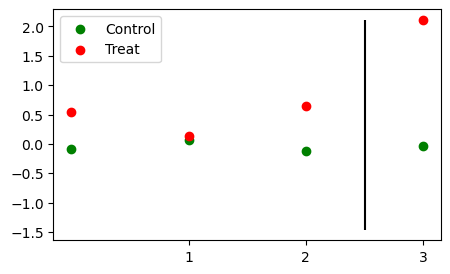

In [7]:
plot_control = df.loc[df['treated']==0].groupby('time')['y'].mean()
plot_treat = df.loc[df['treated']==1].groupby('time')['y'].mean()

fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(5,3))

ax.scatter(x = plot_control.index, y=plot_control, color='green', label='Control')
ax.scatter(x = plot_treat.index, y=plot_treat, color='red', label='Treat')
ax.vlines(x = preT-0.5, ymax=df['y'].max(), ymin=df['y'].min() , color='black')
ax.legend()
ax.set_xticks(np.arange(1,preT+1))
ax.set_xticklabels(np.arange(1,preT+1))
plt.show()


For different auto-correlation values, calculate the atet and bias.
Also run a few bootstraps to rule out simulation noise.

In [20]:
atet_list = []
ar_list = [0.30,0.60,0.90]
pret_list = [2,5,10]
## Ground truth is in terms of standard deviations of the initial period
true_gt = [0.05,1,5]

sim_number = 100

sim_results = pd.DataFrame()
for gt in true_gt:
    for t in pret_list:
        for a in ar_list:
            atet_sim = []
            est_ar_list = []
            for s in range(sim_number):
                df = data_with_ar(ar=a, preT=t, atet=gt, N=N)
                atet_est = did_simp(data=df)
                atet_sim.append(atet_est)
                est_ar_list = np.average( ar_lazy(data=df) )
            atet_ = np.median(atet_sim)
            est_ar_ = np.median(est_ar_list)
            sim_results = pd.concat([sim_results, 
                                    pd.DataFrame(index=[0],data={'ar':a,
                                                                 'est_ar':est_ar_,
                                                                 'pret':t, 
                                                                 'gt':gt,
                                                                 'atet':atet_, 'bias': np.abs(atet_- gt),
                                                                'mape': np.abs(atet_ - gt)/gt})])


In [22]:
# plt.scatter(x=sim_results['ar'], y=sim_results['est_ar'])
# plt.xlabel('AR')
# plt.ylabel('Estimated AR')
# sim_results['est_ar_rnd'] = np.round(sim_results['est_ar'],1)

In [23]:
display(sim_results.describe())

,ar,est_ar,pret,gt,atet,bias,mape
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.600000,0.519335,5.666667,2.016667,1.999152,0.074710,0.436432
std,0.249615,0.203275,3.362691,2.185749,2.191136,0.051072,0.692133
min,0.300000,0.247141,2.000000,0.050000,-0.086761,0.020502,0.004183
25%,0.300000,0.303945,2.000000,0.050000,0.108311,0.037711,0.024881
50%,0.600000,0.507689,5.000000,1.000000,0.956410,0.063465,0.063631
75%,0.900000,0.710858,10.000000,5.000000,4.906230,0.104996,0.708549
max,0.900000,0.831287,10.000000,5.000000,5.159523,0.222007,2.735212


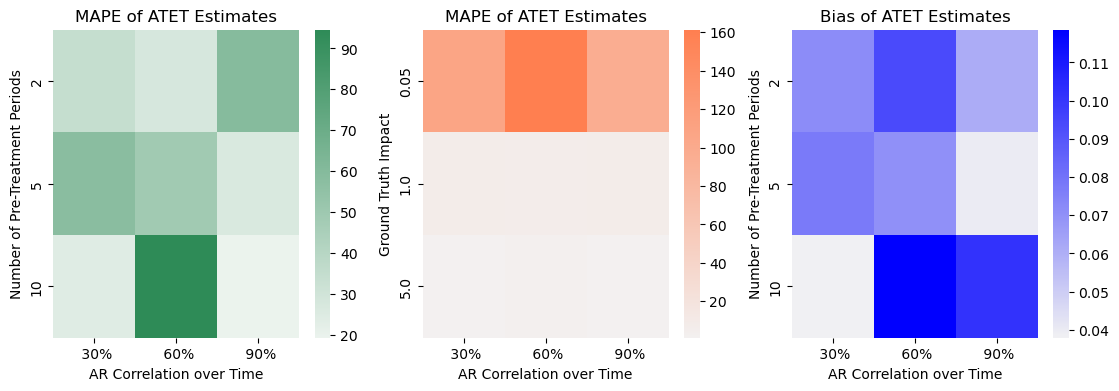

<Figure size 640x480 with 0 Axes>

In [26]:
'''
Look at how bias varies over these different dimensions with heatmaps.
'''
fig, ax = plt.subplots(ncols=3,nrows=1, figsize=(4.5*3, 4))         # Sample figsize in inches

sim_results['mape_disp'] = sim_results['mape']*100


import seaborn as sns
mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='pret', values=['mape_disp'])

sns.heatmap(mape_heatmap,
#             xticklabels = [ np.round(e,2) for e in ar_list],
           xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
            cmap=sns.light_palette("seagreen", as_cmap=True) ,
           ax=ax[0])
ax[0].set_xlabel('AR Correlation over Time')
ax[0].set_ylabel('Number of Pre-Treatment Periods')
ax[0].set_title('MAPE of ATET Estimates')

mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='gt', values=['mape_disp'])

sns.heatmap(mape_heatmap,
#             xticklabels = [ np.round(e,2) for e in ar_list],
           xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
            cmap=sns.light_palette("coral", as_cmap=True) ,
           ax=ax[1])
ax[1].set_xlabel('AR Correlation over Time')
ax[1].set_ylabel('Ground Truth Impact')
ax[1].set_title('MAPE of ATET Estimates')


bias_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='pret', values=['bias'])

sns.heatmap(bias_heatmap,
           xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
            cmap=sns.color_palette("light:b", as_cmap=True) ,
           ax=ax[2])
ax[2].set_xlabel('AR Correlation over Time')
ax[2].set_ylabel('Number of Pre-Treatment Periods')
ax[2].set_title('Bias of ATET Estimates')
plt.show()
plt.tight_layout()


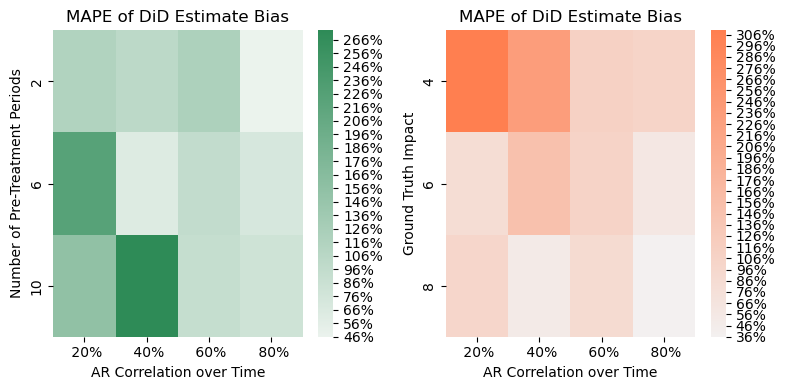

In [116]:
'''
Look at how bias varies over these different dimensions with heatmaps.
'''
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(4*2,4))         # Sample figsize in inches

sim_results['mape_disp'] = sim_results['mape']*100


import seaborn as sns
mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='pret', values=['mape_disp'])

sns.heatmap(mape_heatmap,
#             xticklabels = [ np.round(e,2) for e in ar_list],
           xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
            cmap=sns.light_palette("seagreen", as_cmap=True) ,
           ax=ax[0])
ax[0].set_xlabel('AR Correlation over Time')
ax[0].set_ylabel('Number of Pre-Treatment Periods')
ax[0].set_title('MAPE of DiD Estimate Bias')

# Manually specify colorbar labelling after it's been generated
tick_range = np.arange( mape_heatmap.min().min(),
                      mape_heatmap.max().max(),
                      0.10)
colorbar = ax[0].collections[0].colorbar
colorbar.set_ticks(tick_range)
colorbar.set_ticklabels(['{0:2.0f}%'.format(x*100) for x in tick_range] )


mape_heatmap = pd.pivot_table(data=sim_results, columns='ar',index='gt', values=['mape_disp'])

sns.heatmap(mape_heatmap,
#             xticklabels = [ np.round(e,2) for e in ar_list],
           xticklabels=['{0:3.0f}%'.format(x*100) for x in ar_list],
            cmap=sns.light_palette("coral", as_cmap=True) ,
           ax=ax[1])
ax[1].set_xlabel('AR Correlation over Time')
ax[1].set_ylabel('Ground Truth Impact')
ax[1].set_title('MAPE of DiD Estimate Bias')
tick_range = np.arange( mape_heatmap.min().min(),
                      mape_heatmap.max().max(),
                      0.10)
colorbar = ax[1].collections[0].colorbar
colorbar.set_ticks(tick_range)
colorbar.set_ticklabels(['{0:2.0f}%'.format(x*100) for x in tick_range] )

plt.tight_layout()
plt.show()
